In [3]:
from IPython.display import HTML, display

In [19]:
display(HTML("""<h2>Two Step Forecasting for weather and kWh delivered (using LSTM)</h2> <p>In this model, I would be implementing a two-step forecast that would first predict the weather for a time in the future and then use the predicted weather data as an input for the kWh Delivered forecasting for the model</p>"""))

In [9]:
# Import necessary packages

In [32]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.dates as mdates

In [11]:
# Load the weather data from the weather data folder

In [12]:
data_folder = './caltech_weather_data'
all_data = []

for file_name in os.listdir(data_folder):
    if file_name.endswith('.json'):
        file_path = os.path.join(data_folder, file_name)
        with open(file_path) as json_file:
            data = json.load(json_file)
            for date, details in data['historical'].items():
                hourly_data = details['hourly']
                for hour in hourly_data:
                    hour['date'] = date
                    all_data.append(hour)

# Convert to DataFrame
weather_df = pd.DataFrame(all_data)

# Convert date and time to datetime
weather_df['datetime'] = weather_df.apply(lambda row: datetime.strptime(f"{row['date']} {int(row['time'])//100:02d}:00", "%Y-%m-%d %H:%M"), axis=1)

# Sort by datetime
weather_df.sort_values(by='datetime', inplace=True)
weather_df.set_index('datetime', inplace=True)

# Drop non-numeric columns and keep necessary features
weather_df.drop(columns=['weather_icons', 'weather_descriptions', 'date', 'time'], inplace=True)
weather_df.fillna(method='ffill', inplace=True)

# Display the DataFrame
weather_df.head()


,temperature,wind_speed,wind_degree,wind_dir,weather_code,precip,humidity,visibility,pressure,cloudcover,...,chanceofremdry,chanceofwindy,chanceofovercast,chanceofsunshine,chanceoffrost,chanceofhightemp,chanceoffog,chanceofsnow,chanceofthunder,uv_index
datetime,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,14,6,213,SSW,113,0.0,50,10,1014,20,...,0,0,0,0,0,0,0,0,0,1
2018-04-01 03:00:00,13,4,191,S,113,0.0,60,10,1013,20,...,0,0,0,0,0,0,0,0,0,1
2018-04-01 06:00:00,13,6,196,SSW,113,0.0,58,10,1013,18,...,0,0,0,0,0,0,0,0,0,4
2018-04-01 09:00:00,18,4,220,SW,113,0.0,50,10,1013,19,...,0,0,0,0,0,0,0,0,0,5
2018-04-01 12:00:00,21,12,212,SSW,113,0.0,38,10,1012,11,...,0,0,0,0,0,0,0,0,0,6


In [13]:
# Preprocess the weather data

In [14]:
# Select features and target
features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'cloudcover', 'uv_index']
target = 'temperature'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weather_df[features])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][0]  # Predict temperature
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24 * 7  # Use past 7 days (24 hours each) for prediction
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


(14284, 168, 6) (14284,)
(3572, 168, 6) (3572,)


In [15]:
# Build an LSTM using the data from the model

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


C:\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 168, 50)             │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 88s 187ms/step - loss: 0.0117 - val_loss: 0.0020
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 151s 208ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 135s 192ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 148s 205ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 85s 191ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - loss: 9.6147e-04 - val_loss: 0.0012
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 144s 187ms/step - loss: 9.2135e-04 - val_loss: 0.0015
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - loss: 8.5969e-04 - val_loss: 0.0011
Epoch 9/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - loss: 7.9411e-04 - val_loss: 0.0011
Epoch 10/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 144s 188ms/step - loss: 8.0151e-04 - val_loss: 9.7599e-04


In [17]:
# Evaluate the Model and check for accuracy

112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step
Mean Absolute Error: 1.0638204935087103
Mean Squared Error: 1.8046112146114655


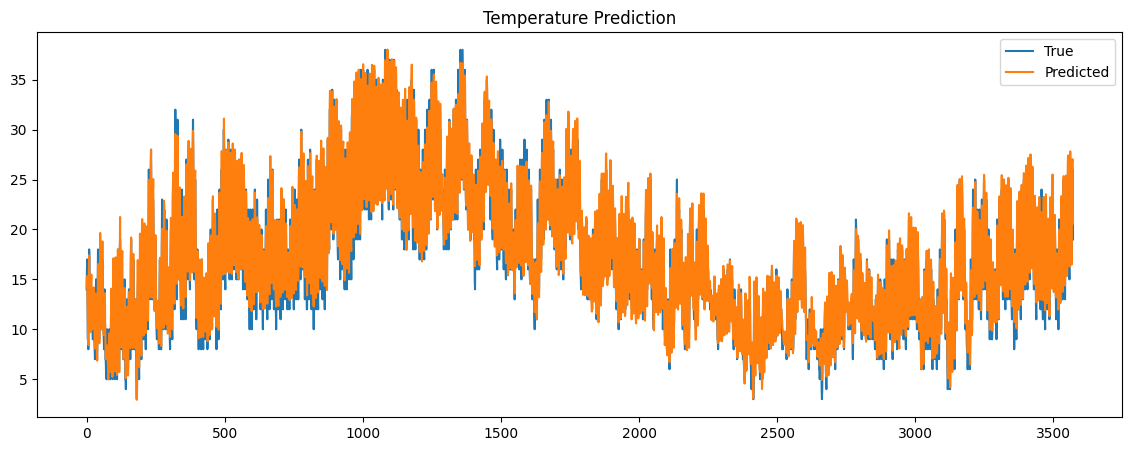

In [18]:
# Predict on validation set
y_pred = model.predict(X_val)

# Inverse transform the predictions
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], len(features)-1))), axis=1))[:,0]
y_val_inv = scaler.inverse_transform(np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], len(features)-1))), axis=1))[:,0]

# Calculate MAE and MSE
mae = mean_absolute_error(y_val_inv, y_pred_inv)
mse = mean_squared_error(y_val_inv, y_pred_inv)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Plot the results
plt.figure(figsize=(14,5))
plt.plot(y_val_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title('Temperature Prediction')
plt.show()


In [20]:
# Predicting the values of other weather factors

In [25]:
data_folder = 'caltech_weather_data'
all_data = []

for file_name in os.listdir(data_folder):
    if file_name.endswith('.json'):
        file_path = os.path.join(data_folder, file_name)
        with open(file_path) as json_file:
            data = json.load(json_file)
            for date, details in data['historical'].items():
                hourly_data = details['hourly']
                for hour in hourly_data:
                    hour['date'] = date
                    all_data.append(hour)

# Convert to DataFrame
weather_df = pd.DataFrame(all_data)

# Convert date and time to datetime
weather_df['datetime'] = weather_df.apply(lambda row: datetime.strptime(f"{row['date']} {int(row['time'])//100:02d}:00", "%Y-%m-%d %H:%M"), axis=1)

# Sort by datetime
weather_df.sort_values(by='datetime', inplace=True)
weather_df.set_index('datetime', inplace=True)

# Drop non-numeric columns and keep necessary features
weather_df.drop(columns=['weather_icons', 'weather_descriptions', 'date', 'time'], inplace=True)
weather_df.fillna(method='ffill', inplace=True)

# Display the DataFrame
weather_df.head()


,temperature,wind_speed,wind_degree,wind_dir,weather_code,precip,humidity,visibility,pressure,cloudcover,...,chanceofremdry,chanceofwindy,chanceofovercast,chanceofsunshine,chanceoffrost,chanceofhightemp,chanceoffog,chanceofsnow,chanceofthunder,uv_index
datetime,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,14,6,213,SSW,113,0.0,50,10,1014,20,...,0,0,0,0,0,0,0,0,0,1
2018-04-01 03:00:00,13,4,191,S,113,0.0,60,10,1013,20,...,0,0,0,0,0,0,0,0,0,1
2018-04-01 06:00:00,13,6,196,SSW,113,0.0,58,10,1013,18,...,0,0,0,0,0,0,0,0,0,4
2018-04-01 09:00:00,18,4,220,SW,113,0.0,50,10,1013,19,...,0,0,0,0,0,0,0,0,0,5
2018-04-01 12:00:00,21,12,212,SSW,113,0.0,38,10,1012,11,...,0,0,0,0,0,0,0,0,0,6


In [27]:
# Select features
features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'cloudcover', 'uv_index']

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weather_df[features])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24 * 7  # Use past 7 days (24 hours each) for prediction
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into training and validation sets
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


(14284, 168, 6) (14284, 6)
(3572, 168, 6) (3572, 6)


In [28]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(len(features)))  # Output layer size matches the number of features

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


C:\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 168, 50)             │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             156 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,031 (129.03 KB)

 Trainable params: 33,031 (129.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 58s 123ms/step - loss: 0.0382 - val_loss: 0.0141
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 0.0108 - val_loss: 0.0116
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - loss: 0.0089 - val_loss: 0.0102
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 61s 137ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 62s 138ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 56s 125ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - loss: 0.0061 - val_loss: 0.0085
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - loss: 0.0061 - val_loss: 0.0086
Epoch 9/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.0061 - val_loss: 0.0083
Epoch 10/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.0060 - val_loss: 0.0084


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
Mean Absolute Error: [ 1.59971327  1.67995961  0.62649786  3.83166705 11.76385329  0.27251024]
Mean Squared Error: [3.89839027e+00 5.13490959e+00 7.14616920e-01 2.57106843e+01
 3.75072070e+02 1.55289214e-01]


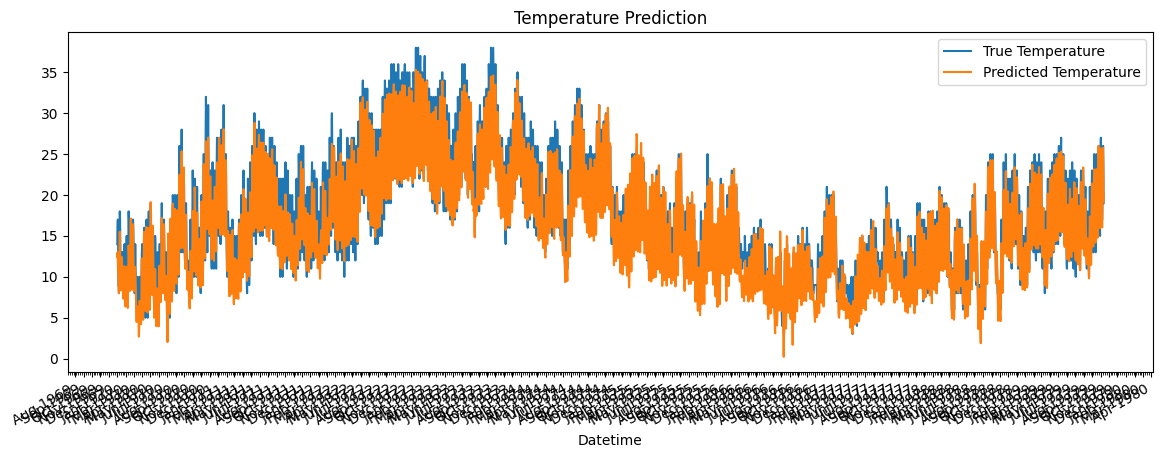

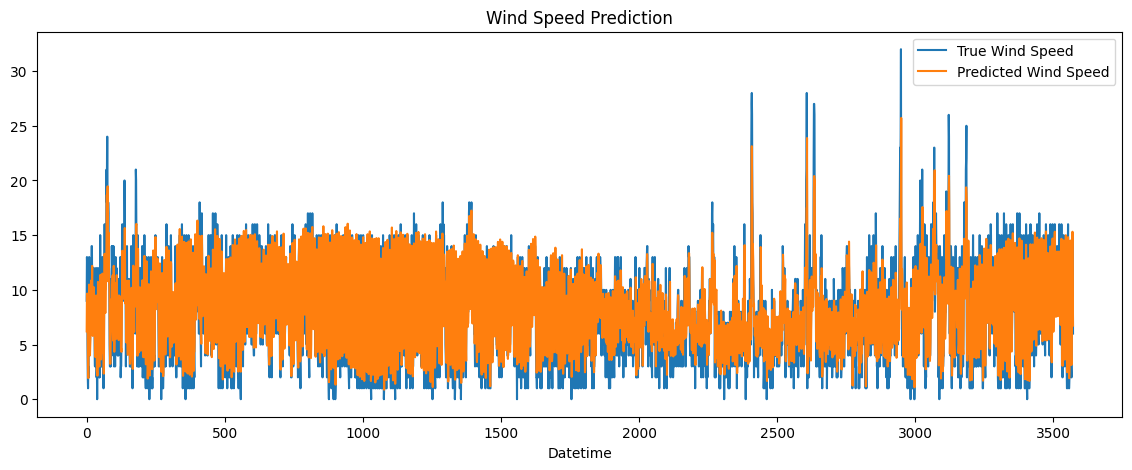

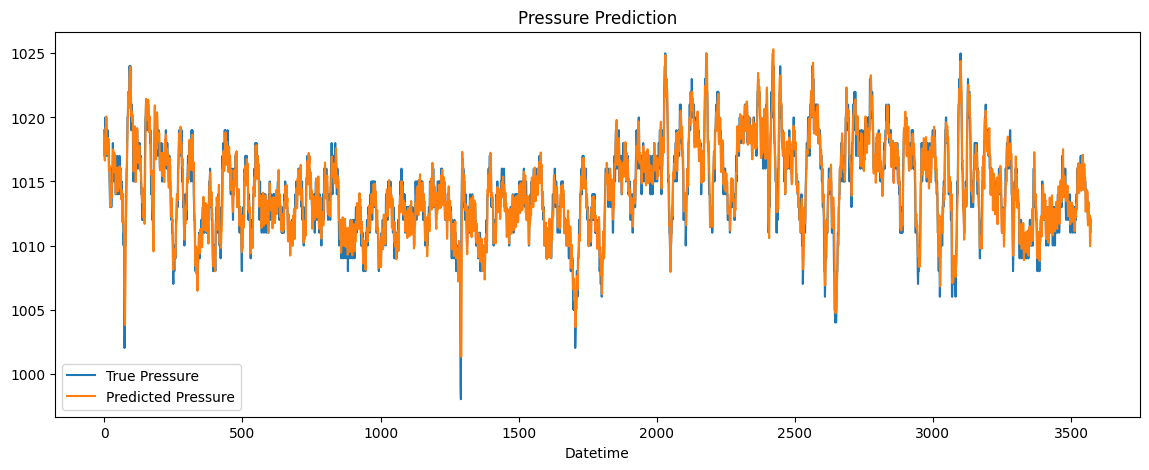

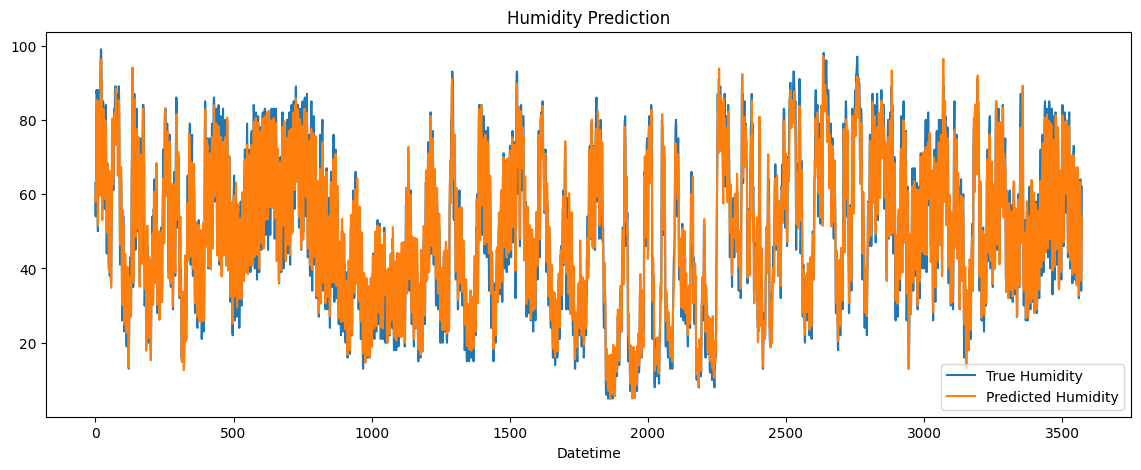

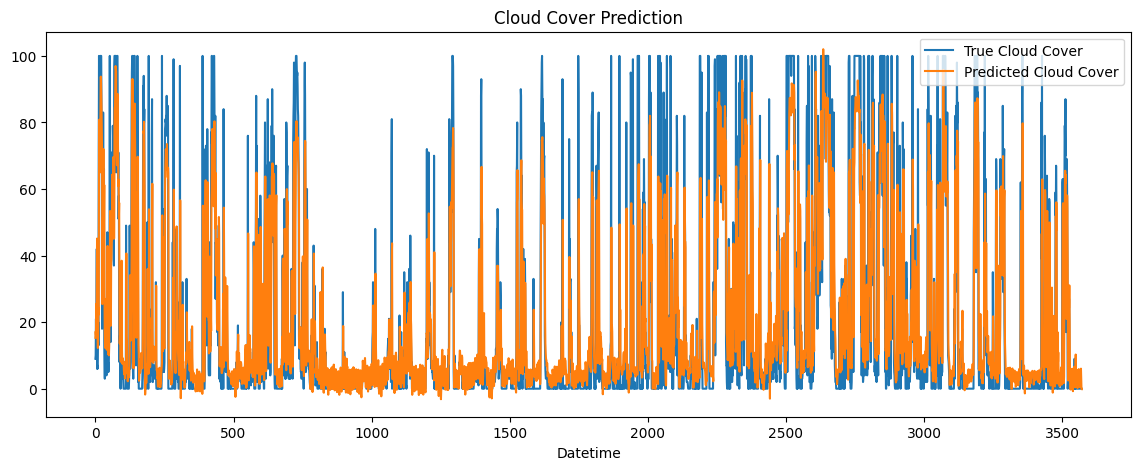

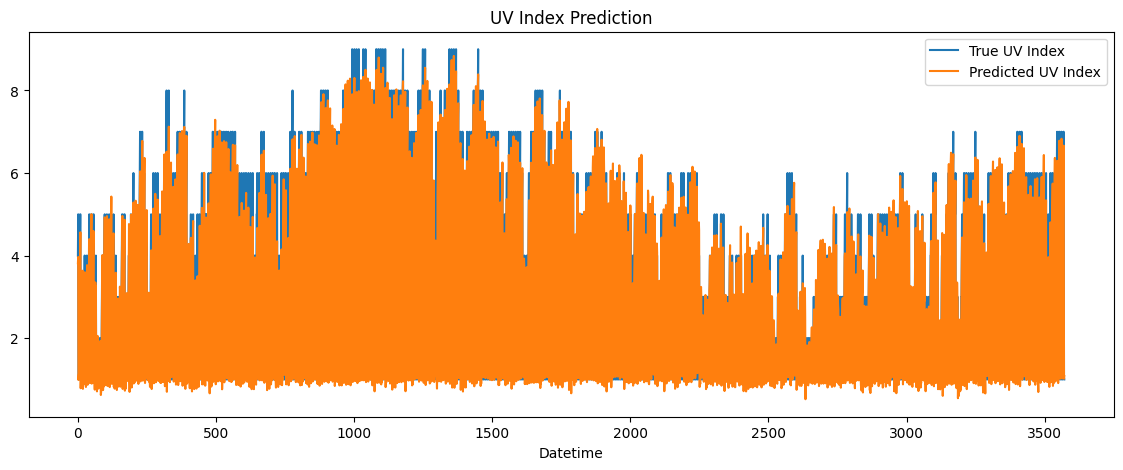

In [35]:
# Predict on validation set
y_pred = model.predict(X_val)

# Inverse transform the predictions and the true values
y_pred_inv = scaler.inverse_transform(y_pred)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, len(features)))

# Calculate MAE and MSE for each feature
mae = mean_absolute_error(y_val_inv, y_pred_inv, multioutput='raw_values')
mse = mean_squared_error(y_val_inv, y_pred_inv, multioutput='raw_values')

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Plot the results for temperature as an example
plt.figure(figsize=(14,5))
plt.plot(y_val_inv[:, 0], label='True Temperature')
plt.plot(y_pred_inv[:, 0], label='Predicted Temperature')

plt.xlabel('Datetime')
plt.legend()
plt.title('Temperature Prediction')
plt.show()

# Plot the results for wind speed as an example
plt.figure(figsize=(14,5))
plt.plot(y_val_inv[:, 1], label='True Wind Speed')
plt.plot(y_pred_inv[:, 1], label='Predicted Wind Speed')
plt.xlabel('Datetime')
plt.legend()
plt.title('Wind Speed Prediction')
plt.show()

# Plot the results for pressure as an example
plt.figure(figsize=(14,5))
plt.plot(y_val_inv[:, 2], label='True Pressure')
plt.plot(y_pred_inv[:, 2], label='Predicted Pressure')
plt.xlabel('Datetime')
plt.legend()
plt.title('Pressure Prediction')
plt.show()

# Plot the results for humidity as an example
plt.figure(figsize=(14,5))
plt.plot(y_val_inv[:, 3], label='True Humidity')
plt.plot(y_pred_inv[:, 3], label='Predicted Humidity')
plt.xlabel('Datetime')
plt.legend()
plt.title('Humidity Prediction')
plt.show()

# Plot the results for cloud cover as an example
plt.figure(figsize=(14,5))
plt.plot(y_val_inv[:, 4], label='True Cloud Cover')
plt.plot(y_pred_inv[:, 4], label='Predicted Cloud Cover')
plt.xlabel('Datetime')
plt.legend()
plt.title('Cloud Cover Prediction')
plt.show()

# Plot the results for UV index as an example
plt.figure(figsize=(14,5))
plt.plot(y_val_inv[:, 5], label='True UV Index')
plt.plot(y_pred_inv[:, 5], label='Predicted UV Index')
plt.xlabel('Datetime')
plt.legend()
plt.title('UV Index Prediction')
plt.show()


In [ ]:


# Load and combine JSON data
data_folder = './caltech_weather_data'
all_data = []

for file_name in os.listdir(data_folder):
    if file_name.endswith('.json'):
        file_path = os.path.join(data_folder, file_name)
        with open(file_path) as json_file:
            data = json.load(json_file)
            for date, details in data['historical'].items():
                hourly_data = details['hourly']
                for hour in hourly_data:
                    hour['datetime'] = datetime.strptime(f"{date} {int(hour['time'])//100:02d}:00", "%Y-%m-%d %H:%M")
                    all_data.append(hour)

# Convert to DataFrame
weather_df = pd.DataFrame(all_data)

# Sort by datetime
weather_df.sort_values(by='datetime', inplace=True)
weather_df.set_index('datetime', inplace=True)

# Drop non-numeric columns and keep necessary features
weather_df.drop(columns=['weather_icons', 'weather_descriptions', 'date', 'time'], inplace=True)
weather_df.fillna(method='ffill', inplace=True)

# Prepare data for LSTM
features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'cloudcover', 'uv_index']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(weather_df[features])

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24 * 7
X, y = create_sequences(scaled_data, SEQ_LENGTH)
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
datetime_index = weather_df.index
validation_index = datetime_index[SEQ_LENGTH + split:len(X) + SEQ_LENGTH]

# Build and train LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, len(features))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(len(features)))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_inv = scaler.inverse_transform(y_pred)
y_val_inv = scaler.inverse_transform(y_val)

# Plot results for UV index with 10-month duration
feature_index = 5  # UV index

plt.figure(figsize=(14, 7))
plt.plot(validation_index, y_val_inv[:, feature_index], label='True UV Index', color='blue')
plt.plot(validation_index, y_pred_inv[:, feature_index], label='Predicted UV Index', color='red')

# Configure x-axis for 10 months duration
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator())  # Minor ticks every week for better granularity
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()  # Rotate date labels

plt.xlabel('Datetime')
plt.ylabel('UV Index')
plt.legend()
plt.title('UV Index Prediction (10 Months)')
plt.grid(True)
plt.show()
